Seattle has a reputation for being a pet friendly city. By some estimates, there are more dogs in the city than there are children, an impressive feat for a place as populous as Seattle. [Seattle's open data portal](https://data.seattle.gov/) contains, among other things, information on [licensed pets](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb).
 
Awesome!

Let's explore the kinds of insights that can be found by looking at this data.

In [91]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud

%matplotlib inline

In [2]:
# Alternatively, download it and read the CSV file locally
license_file = "https://data.seattle.gov/api/views/jguv-t9rb/rows.csv?accessType=DOWNLOAD"

pets = pd.read_csv(license_file)

## Cleaning the data
Let's inspect the dataset to ensure it's properly cleaned before any analysis is run on it.

First, what does our data look like?

In [3]:
pets.shape  # (rows, columns)

(53663, 7)

In [4]:
pets.columns

Index(['License Issue Date', 'License Number', 'Animal's Name', 'Species',
       'Primary Breed', 'Secondary Breed', 'ZIP Code'],
      dtype='object')

Let's rename the columns so they're easier to work with

In [5]:
pets.columns = [
    "license_issued", "license", "name",
    "species", "primary_breed",
    "secondary_breed", "zipcode",
]

In [6]:
# how many NaNs does each colum have?
# https://stackoverflow.com/a/26266451
pets.isna().sum()

license_issued         0
license                0
name                 709
species                0
primary_breed          0
secondary_breed    32083
zipcode              361
dtype: int64

Given the amount of `NaN` values in the `secondary_breed` column, most owners either don't know what breed their pet is mixed with, or left that section blank when applying for a license.

A fair number of licenses also don't have the `name` listed. It's possible these animals were either babies or recently adopted at the time of their licensing.

![cute beagle puppy](https://images.pexels.com/photos/460823/pexels-photo-460823.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)
Cute!

In either case, let's replace the missing values from `secondary_breed` and drop the rest of the `NaN`s

In [7]:
pets = (pets
    .fillna({"secondary_breed": ""})
    .dropna()
)

pets.describe()

,license_issued,license,name,species,primary_breed,secondary_breed,zipcode
count,52596,52596,52596,52596,52596,52596,52596
unique,1061,52570,14006,4,335,256,154
top,January 16 2018,133239,Lucy,Dog,Domestic Shorthair,,98115
freq,448,3,457,35278,9976,31570,4851


`license_issued` looks like it's a string - it would be more useful as a datetime object

In [8]:
pets["license_issued"] = pd.to_datetime(pets["license_issued"])

There are also duplicate licenses that we should get rid of

In [9]:
pets.drop_duplicates(subset=["license"], inplace=True)

Our data should be clean enough now, let's move on to the analysis.

## Cats & Dogs
Almost all licenses are for either cats or dogs.

![cat and dog together](https://images.pexels.com/photos/46024/pexels-photo-46024.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260)

In [10]:
pets.groupby("species").species.count().sort_values(ascending=False)

species
Dog     35260
Cat     17268
Goat       38
Pig         4
Name: species, dtype: int64

In [11]:
cats = pets[pets.species == "Cat"]
dogs = pets[pets.species == "Dog"]

### Naming
Let's discover what people name their cats and dogs

In [116]:
cat_names = cats.name.value_counts()
dog_names = dogs.name.value_counts()

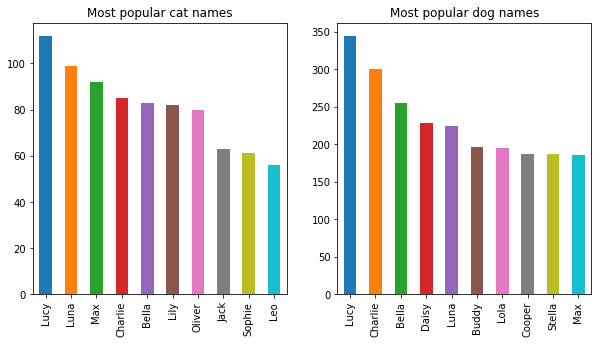

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cat_names.head(10).plot.bar(
    title="Most popular cat names",
    ax=ax[0],
)

dog_names.head(10).plot.bar(
    title="Most popular dog names",
    ax=ax[1],
)

plt.show()

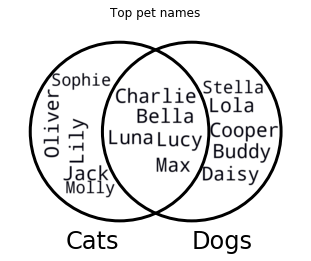

In [105]:
fig, ax = plt.subplots(1, 1)

ax.set_title("Top pet names")
venn2_wordcloud(
    [
        set(cat_names.head(10).index),
        set(dog_names.head(10).index),
    ],
    set_labels=("Cats", "Dogs"),
    ax=ax,
)

plt.show()

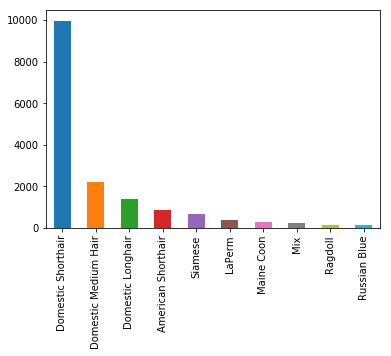

In [120]:
cats.primary_breed.value_counts().head(10).plot.bar(logy=False)

In [7]:
dog_breeds = dogs.groupby("Primary Breed")["Primary Breed"].count().sort_values(ascending=False)

top_n = 10
top_dog_breeds = dog_breeds[:top_n]

Primary Breed
Retriever, Labrador           5050
Retriever, Golden             1885
Chihuahua, Short Coat         1858
German Shepherd               1015
Terrier                        989
Australian Shepherd            929
Border Collie                  829
Poodle, Miniature              801
Terrier, American Pit Bull     698
Shih Tzu                       650
Name: Primary Breed, dtype: int64

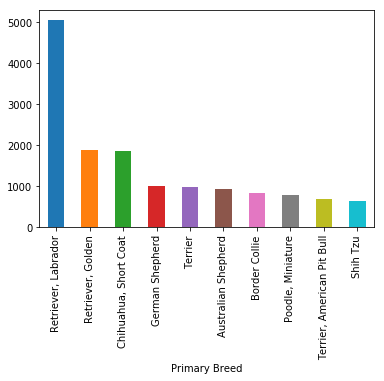

In [8]:
# with plt.xkcd():
top_dog_breeds.plot.bar()
top_dog_breeds

Animal's Name
Lucy       344
Charlie    299
Bella      254
Daisy      228
Luna       223
Name: Animal's Name, dtype: int64

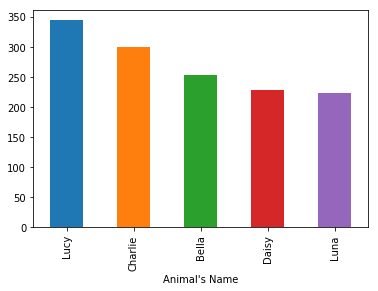

In [9]:
dog_names = dogs.groupby("Animal's Name")["Animal's Name"].count().sort_values(ascending=False)

n_names = 5
top_dog_names = dog_names[:n_names]
# with plt.xkcd():
top_dog_names.plot.bar()
top_dog_names

# This is all fine and dandy, but where can I find the corgis?
(I need more of them in my life)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Welchcorgipembroke.JPG/1024px-Welchcorgipembroke.JPG)
Image courtesy of Wikipedia's page on [Welsh Corgis](https://en.wikipedia.org/wiki/Welsh_Corgi)

In [10]:
is_primary_breed_corgi = dogs["Primary Breed"].str.contains("corgi", case=False)
is_secondary_breed_corgi = dogs["Secondary Breed"].str.contains("corgi", case=False)

corgis = dogs[is_primary_breed_corgi | is_secondary_breed_corgi]

In [11]:
corgis

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
18165,November 07 2015,S101423,Midge,Dog,"Welsh Corgi, Pembroke",,98106
18196,November 17 2015,903537,Chelsea,Dog,"Welsh Corgi, Pembroke",,98126
18223,November 23 2015,27139,Teddy,Dog,"Welsh Corgi, Pembroke","Chihuahua, Short Coat",98146
18243,December 01 2015,904550,Ruby,Dog,"Welsh Corgi, Cardigan",Shepherd,98117
18364,February 03 2016,76769,Stella,Dog,Terrier,"Welsh Corgi, Cardigan",98199
18374,February 13 2016,831739,Bella,Dog,"Welsh Corgi, Cardigan",Mix,98118
18578,July 12 2016,444009,Jackie,Dog,Border Collie,"Welsh Corgi, Cardigan",98102
18620,July 14 2016,S101097,Snowball,Dog,"Welsh Corgi, Cardigan",Mix,98126
18651,July 16 2016,440788,Pales,Dog,"Welsh Corgi, Cardigan",,98105
18711,July 20 2016,441748,Laika,Dog,"Dachshund, Standard Smooth Haired","Welsh Corgi, Cardigan",98118


Wait, there are duplicate license numbers in here

In [12]:
corgis[corgis.duplicated(subset=["License Number"])]

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code


At this point, I contacted the dataset owner to make sure they were aware of the fact that duplicate entries exist.

In [13]:
import folium
import requests

SEATTLE_COORDINATES = (47.63, -122.27)
DEFAULT_ZOOM = 10
# Thank you, SeattleIO, for providing this!
ZIPCODE_GEO_URL = (
    "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/zip-codes.geojson"
)
ZIPCODE_GEO_TEXT = requests.get(ZIPCODE_GEO_URL).text

def plot_data_by_zipcode(data,
                         location=SEATTLE_COORDINATES,
                         zoom_start=DEFAULT_ZOOM,
                         geo_data=ZIPCODE_GEO_TEXT, 
                         key_on="feature.properties.ZCTA5CE10",
                         fill_color="PuBuGn",
                         **kwargs):
    """Plot data on a choropleth map
    
    With the exception of map_coordinates and default_zoom, all arguments
    in this function are passed to folium.Map.choropleth. map_coordinates
    and default_zoom arguments are passed in as parameters to the folium.Map
    constructor.
    
    Args:
        data - data to pass into the choropleth map. Corresponds to the
               data argument passed into folium.Map.choropleth and is usually
               a pandas DataFrame or Series.
        **kwargs - Additional arguments to pass to folium.Map.choropleth
        
    Returns:
        A folium.Map instance containing a choropleth of mapped data
    """    
    map_ = folium.Map(location=location, zoom_start=zoom_start)

    map_.choropleth(
        geo_data=geo_data,
        data=data,
        key_on=key_on,
        fill_color=fill_color,
        **kwargs,
    )
    
    return map_

In [14]:
corgi_count_by_zipcode = corgis.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(data=corgi_count_by_zipcode, legend_name="Seattle Corgi Population by Zipcode")

# Is that any different than the distribution of all dogs?

In [20]:
dogs_by_zipcode = dogs.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(dogs_by_zipcode, legend_name="Dog Count by Zipcode")

# Where do the cool cats live?

In [16]:
cats = pets[pets.Species == "Cat"]

cats_by_zipcode = cats.groupby("ZIP Code")["ZIP Code"].count()

plot_data_by_zipcode(data=cats_by_zipcode, legend_name="Cat Count by Zipcode")

# Conclusion - go to Green Lake